In [1]:
import kmodels as kmk
import torch 
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
n = 10000
n_features = 10
binary_dim = 0
float_dim = n_features - binary_dim
x_bin = np.random.randint(2, size=(n, binary_dim))
x_float = np.random.rand(n, float_dim)
x = np.concatenate((x_bin, x_float), axis=1)
y = np.sin(x[:,0]) + np.cos(x[:,1])
# # y will be piecewise linear function of x using binary dim as a switch
# y = np.zeros(n)
# for i in range(n):
#     if x_bin[i] == 0:
#         y[i] = np.sum(x_float[i])
#     else:
#         y[i] = np.sum(x_float[i]**2)
x.shape, y.shape, x, x_bin

((10000, 10),
 (10000,),
 array([[0.1194922 , 0.53838045, 0.1524641 , ..., 0.65380512, 0.14608518,
         0.65134791],
        [0.64006304, 0.32410967, 0.48230019, ..., 0.6967407 , 0.7420642 ,
         0.33564953],
        [0.68232645, 0.36530413, 0.55144371, ..., 0.12324705, 0.47250347,
         0.16469272],
        ...,
        [0.76958349, 0.05722626, 0.23376806, ..., 0.74776321, 0.60394879,
         0.94208693],
        [0.37042494, 0.75787078, 0.72989883, ..., 0.4987222 , 0.72920548,
         0.46995113],
        [0.04888459, 0.84270939, 0.94685361, ..., 0.28583863, 0.12039865,
         0.75574954]]),
 array([], shape=(10000, 0), dtype=int32))

In [3]:
def scale_data(x, binary_dim=0):
    if binary_dim>0:
        bin_scaler = MinMaxScaler()
        float_scaler = StandardScaler()
        x_bin = bin_scaler.fit_transform(x[:, :binary_dim])
        x_float = float_scaler.fit_transform(x[:, binary_dim:])
        print('binary scaler: ', x_bin.shape)
        print('float scaler: ', x_float.shape)
        x = np.concatenate((x_bin, x_float), axis=1)
    else:
        bin_scaler = None
        float_scaler = StandardScaler()
        x = float_scaler.fit_transform(x)
        print('float scaler: ', x.shape)
    return x, bin_scaler, float_scaler

x, bin_scaler, float_scaler = scale_data(x, binary_dim=binary_dim)
x.shape

float scaler:  (10000, 10)


(10000, 10)

In [4]:
from torch.utils.data import TensorDataset
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
dataset = TensorDataset(x, y)

In [11]:
from sklearn.model_selection import GridSearchCV
param_dist = {'fc_layers':[3, 5], 'lr_init':[0.01, 0.001], 'kernel_size':[3, 5]}
reg = kmk.Trainer(**{'conv_layers':1, 'estimator_type':'CNN', 'batch_size':1000, 'fc_size':10,
                     'epochs':101, 'fc_size':10, 'verbose':10,'reg_factor':0})
grid_ = GridSearchCV(reg, param_dist, cv=2, verbose=1, n_jobs=1)

In [12]:
grid_.fit(x, y)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
====> Epoch: 0 Average loss: 0.003573536 Time: 0.30
Loss components:  {}
====> Epoch: 10 Average loss: 0.000251950 Time: 0.07
Loss components:  {}
====> Epoch: 20 Average loss: 0.000179158 Time: 0.07
Loss components:  {}
====> Epoch: 30 Average loss: 0.000168426 Time: 0.07
Loss components:  {}
====> Epoch: 40 Average loss: 0.000164178 Time: 0.07
Loss components:  {}
====> Epoch: 50 Average loss: 0.000161885 Time: 0.26
Loss components:  {}
====> Epoch: 60 Average loss: 0.000160186 Time: 0.07
Loss components:  {}
====> Epoch: 70 Average loss: 0.000158509 Time: 0.07
Loss components:  {}
====> Epoch: 80 Average loss: 0.000156956 Time: 0.08
Loss components:  {}
====> Epoch: 90 Average loss: 0.000155436 Time: 0.07
Loss components:  {}
====> Epoch: 100 Average loss: 0.000153450 Time: 0.26
Loss components:  {}
====> Epoch: 0 Average loss: 0.009623623 Time: 0.07
Loss components:  {}
====> Epoch: 10 Average loss: 0.000373208 Time: 0.07


GridSearchCV(cv=2,
             estimator=<kmodels.utils.Trainer object at 0x00000178C94B18A0>,
             n_jobs=1,
             param_grid={'fc_layers': [3, 5], 'kernel_size': [3, 5],
                         'lr_init': [0.01, 0.001]},
             verbose=1)

In [13]:
reg = grid_.best_estimator_
reg.set_params(**{'epochs':101})
reg.config

{'epochs': 101,
 'device': 'cpu',
 'conv_layers': 1,
 'batch_size': 1000,
 'fc_size': 10,
 'verbose': 10,
 'reg_factor': 0,
 'lr_init': 0.01,
 'metric': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)>,
 'lr_gamma': 0.1,
 'scheduler': kmodels.utils.LR_scheduler,
 'is_VAE': False,
 'n_inputs': 10,
 'n_outputs': 1,
 'binary_dim': 0,
 'beta': 0,
 'gamma': 0,
 'binary_dim_y': 0,
 'fc_layers': 5,
 'out_channels': [3],
 'kernel_size': 5,
 'conv_padding': 0,
 'train_observations': 10000,
 'estimator_type': 'CNN'}

In [14]:
print(x.shape, y.shape)
reg.fit(x,y.reshape(-1,1))
reg

torch.Size([10000, 10]) torch.Size([10000, 1])
====> Epoch: 0 Average loss: 0.020305963 Time: 0.17
Loss components:  {}
====> Epoch: 10 Average loss: 0.000522518 Time: 0.16
Loss components:  {}
====> Epoch: 20 Average loss: 0.000297721 Time: 0.16
Loss components:  {}
====> Epoch: 30 Average loss: 0.000271364 Time: 0.15
Loss components:  {}
====> Epoch: 40 Average loss: 0.000267948 Time: 0.15
Loss components:  {}
====> Epoch: 50 Average loss: 0.000262060 Time: 0.16
Loss components:  {}
====> Epoch: 60 Average loss: 0.000261302 Time: 0.17
Loss components:  {}
====> Epoch: 70 Average loss: 0.000263491 Time: 0.15
Loss components:  {}
====> Epoch: 80 Average loss: 0.000256148 Time: 0.16
Loss components:  {}
====> Epoch: 90 Average loss: 0.000255832 Time: 0.15
Loss components:  {}
====> Epoch: 100 Average loss: 0.000254527 Time: 0.18
Loss components:  {}


In [15]:
reg.score(x,y.reshape(-1,1)), [i for i in reg.estimator.modules()]

(0.6801018842859619,
 [CNN(conv_layers=1, fc_layers=5, fc_size=10, kernel_size=5, n_inputs=10,
      out_channels=[3]),
  ModuleList(),
  Linear(in_features=10, out_features=10, bias=True),
  ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  ),
  Linear(in_features=10, out_features=10, bias=True),
  Linear(in_features=10, out_features=10, bias=True),
  Linear(in_features=10, out_features=10, bias=True),
  Linear(in_features=10, out_features=10, bias=True),
  Linear(in_features=10, out_features=1, bias=True)])

In [16]:
reg.estimator_params

{'estimator_type': 'CNN',
 'fc_layers': 5,
 'fc_size': 10,
 'out_channels': [3],
 'kernel_size': 5,
 'conv_layers': 1,
 'n_inputs': 10,
 'n_outputs': 1,
 'conv_padding': 0}

In [17]:
# plot the results of the grid search
import pandas as pd
df = pd.DataFrame(grid_.cv_results_)
# make a contour plot where color is the score and x and y are the parameters (lr_init and fc_layers)
fig = px.scatter_3d(df, x='param_lr_init', y='param_fc_layers', z='mean_test_score', color='mean_test_score')
fig.show()

torch.Size([10000, 1]) torch.Size([10000, 1])


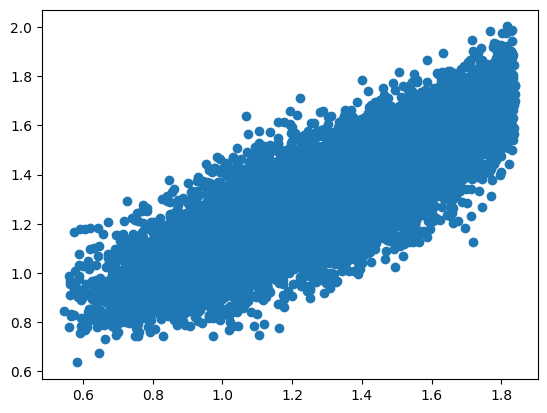

In [18]:
#plt.plot(reg.losses)
pred = reg.predict(x).reshape(-1, 1)
print(pred.shape, y.shape)
plt.scatter(y.reshape(-1, 1), pred)

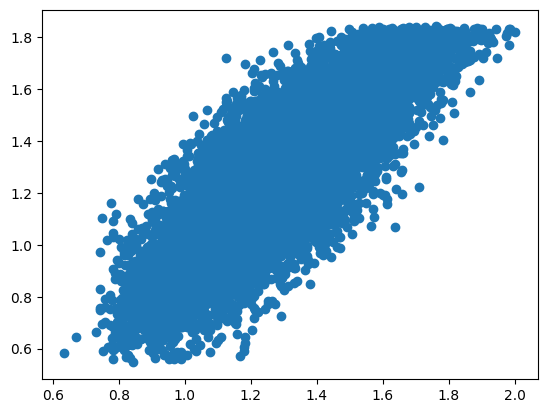

In [19]:
# best_model = reg
# #plt.plot(best_model.losses)
# print(grid_.best_params_)
# print(grid_.best_score_)
best_model = reg
pred = best_model.predict(x).reshape(-1,1)
plt.plot(pred.detach().numpy(), y.detach().numpy().reshape(-1,1), 'o')

In [ ]:
trainer = kmk.trainer(**{'binary_dim':0, 'binary_dim_y':0, 'model_type':'NN', 'epochs':11,'lr_init':1e-3,
                       'batch_size':1000,'beta':0, 'gamma':0, 'layers':5, 'layer_size':100})
trainer.fit(x.reshape(-1, 1), y.reshape(-1, 1))

AttributeError: module 'kmodels' has no attribute 'trainer'

In [ ]:
plt.plot(trainer.losses)

In [ ]:
pred = trainer.predict(x.reshape(-1,1)).reshape(-1,1)
plt.scatter(pred, y)

In [ ]:
x

In [ ]:
new_model = kmk.NN(n_inputs=x.shape[1], n_outputs=y.shape[1], layers=2, layer_size=50)
reg = kmk.trainer({'n_inputs':x.shape[1], 'n_outputs':y.shape[1], 'layers':2, 'layer_size':50})
params = reg.params
reg.set_params(**params)

In [ ]:
from ray import tune
import ray
import os

def train_model(config: dict):
    trainer = kmk.Trainer({'binary_dim':0, 'binary_dim_y':0, 'model_type':'NN', 'epochs':11,'lr_init':1e-3,
                           'batch_size':1000,'beta':0, 'gamma':0, 'layers':5, 'layer_size':100})
    trainer.set_params(**config)
    trainer.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    return trainer


In [ ]:
from ray.train.torch import TorchTrainer
from ray.air import ScalingConfig
# get the logging
ray.init(num_cpus=1, log_to_driver=False)
# For GPU Training, set `use_gpu` to True.
# trainer = Trainer(backend="torch", num_workers=2, use_gpu=True)
scaling_config = ScalingConfig(train_model, num_workers=1)
config = {}
trainer = TorchTrainer(train_loop_per_worker=train_model, train_loop_config=config)
trainer.fit()

In [ ]:
import ray

# Connect to the Ray cluster.
ray.init()

# Define a remote function to check the status of a worker.
@ray.remote
def check_worker_status(worker_id):
    # Add your logic here to check the worker's status.
    # For example:
    # return True if the worker is healthy, otherwise False.
    return True

# Get a list of all workers in the cluster.
all_workers = ray.nodes()

# Check the status of each worker in parallel.
worker_statuses = ray.get([check_worker_status.remote(worker["NodeID"]) for worker in all_workers])

# Print the status of each worker.
for worker, status in zip(all_workers, worker_statuses):
    print(f"Worker {worker['NodeID']} is {'healthy' if status else 'unhealthy'}.")


In [ ]:
trainer = train_model({'epochs':51})
plt.plot(trainer.losses)


In [ ]:
pred = trainer.predict(trainer.x).reshape(-1,1)
plt.scatter(pred, trainer.y)

In [ ]:
model = kmk.NN(n_inputs=x.shape[1], n_outputs=y.shape[1], layers=2, layer_size=50, change_layers=0)
model

In [ ]:
tlnn = kmk.TLNN(model, x, change_layers=1)
tlnn

In [ ]:
model.__init__(**model.params)